In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from scipy.optimize import minimize
import math

Epoch 0/1000, Loss: 15500646.0


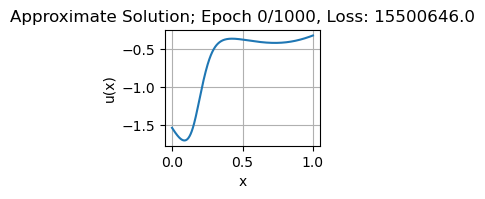

Epoch 100/1000, Loss: 2856.685546875


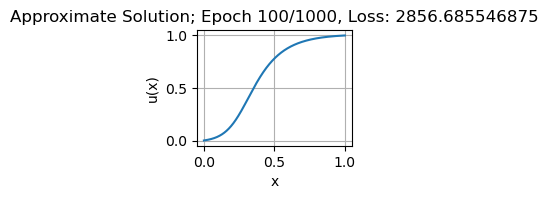

Epoch 200/1000, Loss: 2267.6904296875


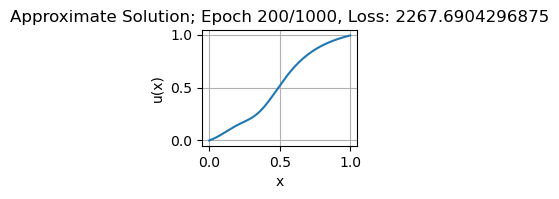

Epoch 300/1000, Loss: 2239.86767578125


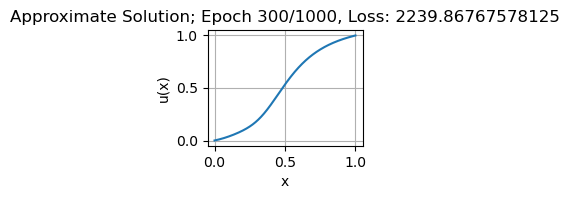

Epoch 400/1000, Loss: 1913.0333251953125


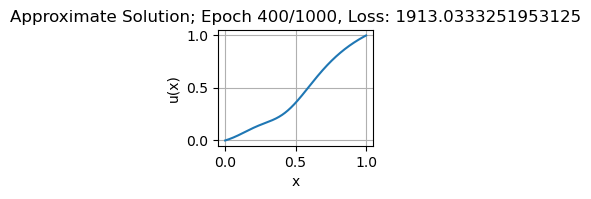

Epoch 500/1000, Loss: 1795.237060546875


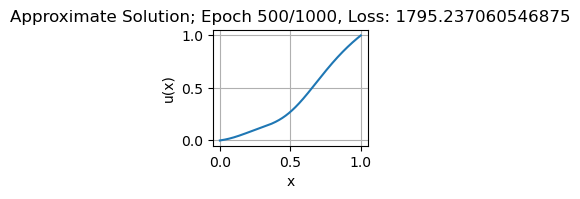

Epoch 600/1000, Loss: 2014.4365234375


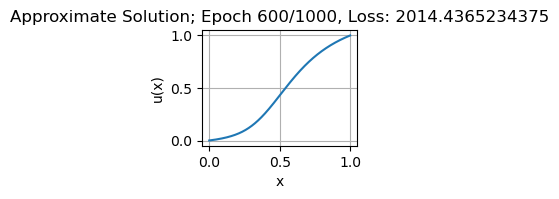

Epoch 700/1000, Loss: 1828.953369140625


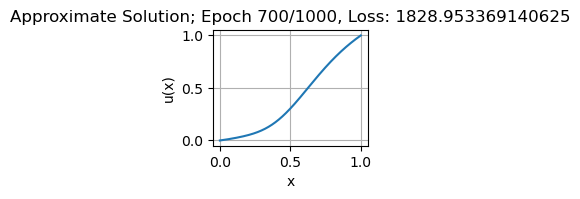

Epoch 800/1000, Loss: 1763.494384765625


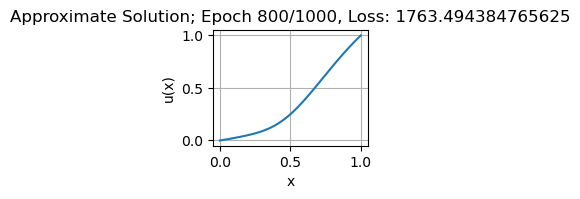

Epoch 900/1000, Loss: 1744.3194580078125


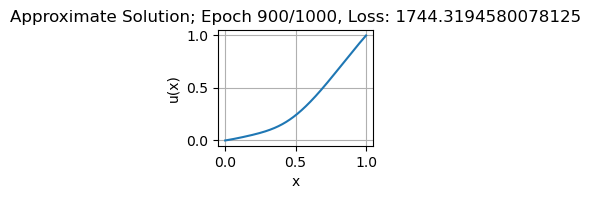

In [8]:
class DeepRitzNet(nn.Module):
    def __init__(self,num_layers = 5, hidden_size = 50, output_size = 1, input_size = 1):
        
        super().__init__()
        h = hidden_size
        assert num_layers >=2
        self.fc = nn.ModuleList()
        self.ln = nn.ModuleList()
        self.fc.append(nn.Linear(input_size,h))
        self.ln.append(nn.LayerNorm(h))
        for _ in range(num_layers -2):
            self.fc.append(nn.Linear(h, h))
            self.ln.append(nn.LayerNorm(h))
        self.fc.append(nn.Linear(h, output_size))

    def forward(self, x):
        for i in range(len(self.fc)-1):
            # for layer in self.fc[:-1]:
            layer = self.fc[i]
            layernorm = self.ln[i]
            x = layer(x)
            x = layernorm(x)
            x = F.relu(x)**3
        x = self.fc[-1](x)
        return x
# class DeepRitzNet(nn.Module):
#     def __init__(self):
#         super(DeepRitzNet, self).__init__()
#         self.layer1 = nn.Linear(1, 20)
#         self.layer2 = nn.Linear(20, 20)
#         self.layer3 = nn.Linear(20, 20)
#         self.layer4 = nn.Linear(20, 1)

#     def forward(self, x):
#         x = torch.tanh(self.layer1(x))
#         x = torch.tanh(self.layer2(x))
#         x = torch.tanh(self.layer3(x))
#         x = self.layer4(x)
#         return x

    
def energy_functional(u, x, f):
    u_prime = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_doubleprime = torch.autograd.grad(u_prime, x, grad_outputs=torch.ones_like(u_prime), create_graph=True, retain_graph=True)[0]

    energy = 0.5 * torch.sum((u_prime * u_prime) + torch.square(u)) - torch.sum(f * u)
    
    # (u - g) >= 0
#     obstacle_term = torch.min((u - g), torch.zeros_like(u - g))
#     energy += (10**3) * torch.sum(torch.square(obstacle_term))
    
    energy += (10**6) * torch.sum(torch.square(u[0]) + torch.square(u[-1] - torch.ones_like(u[-1])))
    return torch.mean(energy)

def train(model, x, g, epochs=1000, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        u = model(x)
        
        energy = energy_functional(u, x, g)
        loss = energy  
        loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
            x_np = x.detach().numpy()
            u_np = model(x)
            u_np = u_np.detach().numpy()

            plt.figure(figsize=(2, 1.5))
            plt.plot(x_np, u_np)
            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.title('Approximate Solution; '+f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
            plt.grid(True)
            plt.show()
# def g(x):
#     # x = np.linspace(0,1,100)
#     out = torch.zeros_like(x)
#     cond1 = (x>=0) * (x<0.25)
#     cond2 = (x>= 0.25) * (x< 0.5)
#     cond3 = (x>=0.5) * (x < 0.75)
#     cond4 = (x>=0.75) * (x <= 1.0)
#     x1 = x[cond1]
#     x2 = x[cond2]
#     x3 = x[cond3]
#     x4 = x[cond4]
#     out[cond1] = 100 * x1**2
#     out[cond2] = 100 * x2 * (1 - x2) - 12.5
#     out[cond3] = 100 * x3 * (1 - x3) - 12.5
#     out[cond4] = 100 * (1 - x4)**2
#     # if config['visual'] == True:
#     #     plt.plot(x,g);plt.show()
#     return out

def f(x):
    return torch.square(x) - 2 * torch.ones_like(x)

x = torch.linspace(0, 1, 1400).reshape(-1, 1)
x.requires_grad_(True)

fx = f(x)  # obstacle function

model_2 = DeepRitzNet()

train(model_2, x, fx)






NameError: name 'u_approx_np' is not defined

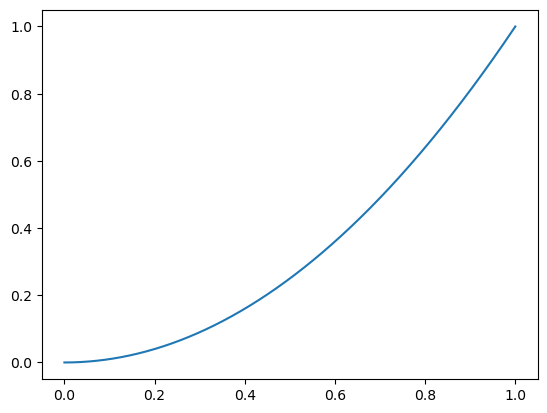

In [7]:
def cal_u_exact(x):
    # x = np.linspace(0,1,100)
    x = x.detach().numpy()
    return np.square(x)
u_exact_np = cal_u_exact(x)
plt.plot(x.detach().numpy(), u_exact_np, label='Exact u(x)')
plt.plot(x, u_approx_np, label='Approximate Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Approximate Solution')
plt.legend()
plt.grid(True)
plt.show()